In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.17

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.11/dist-packages/tensorflow-2.18.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.18.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.2

In [ ]:
#------------------------------------------------------------
# Import necessary libraries
#------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras.layers import Input, MaxPooling2D, concatenate, Conv2D, UpSampling2D, SpatialDropout2D, BatchNormalization, Activation
from tensorflow.keras import backend as K
from tensorflow.keras import Model, utils
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from google.cloud import storage
import numpy as np
import os
import csv
import time
import tarfile
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, show
import glob
from IPython.display import Image, display, clear_output
import cv2

tf.__version__


'2.17.0'

In [ ]:
#------------------------------------------------------------
# Run to generate credentials - paste the block of code from
# "credentials for BE 547 lab" into this section
#------------------------------------------------------------


In [ ]:
#------------------------------------------------------------
# Download the data
#------------------------------------------------------------
client = storage.Client.from_service_account_json("auth.json")
bucket = client.get_bucket("pennclassdata")
blob = bucket.blob("class_data.tar")
blob.download_to_filename("class_data.tar")
# Untar it
file = tarfile.open('class_data.tar')
file.extractall('data')
file.close()
print("Download complete")

print("Number of training images:",len(os.listdir("data/train/image/dummy_class")))
print("Number of validation images:",len(os.listdir("data/valid/image/dummy_class")))
print("Number of testing images:",len(os.listdir("data/test/image/dummy_class")))

Download complete
Number of training images: 2989
Number of validation images: 1037
Number of testing images: 807


In [ ]:
#------------------------------------------------------------
# Load helper functions
#------------------------------------------------------------
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = BatchNormalization(name=prefix + "_bn")(conv)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv

def get_simple_unet(input_shape):
    img_input = Input((input_shape + (1,)))
    conv1 = conv_block_simple(img_input, 32, "conv1_1")
    conv1 = conv_block_simple(conv1, 32, "conv1_2")
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), padding="same", name="pool1")(conv1)

    conv2 = conv_block_simple(pool1, 64, "conv2_1")
    conv2 = conv_block_simple(conv2, 64, "conv2_2")
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), padding="same", name="pool2")(conv2)

    conv3 = conv_block_simple(pool2, 128, "conv3_1")
    conv3 = conv_block_simple(conv3, 128, "conv3_2")
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), padding="same", name="pool3")(conv3)

    conv4 = conv_block_simple(pool3, 256, "conv4_1")
    conv4 = conv_block_simple(conv4, 256, "conv4_2")
    conv4 = conv_block_simple(conv4, 256, "conv4_3")

    up5 = concatenate([UpSampling2D()(conv4), conv3], axis=3)
    conv5 = conv_block_simple(up5, 128, "conv5_1")
    conv5 = conv_block_simple(conv5, 128, "conv5_2")

    up6 = concatenate([UpSampling2D()(conv5), conv2], axis=3)
    conv6 = conv_block_simple(up6, 64, "conv6_1")
    conv6 = conv_block_simple(conv6, 64, "conv6_2")

    up7 = concatenate([UpSampling2D()(conv6), conv1], axis=3)
    conv7 = conv_block_simple(up7, 32, "conv7_1")
    conv7 = conv_block_simple(conv7, 32, "conv7_2")

    conv7 = SpatialDropout2D(0.2)(conv7)

    prediction = Conv2D(1, (1, 1), activation="sigmoid", name="prediction")(conv7)
    model = Model(img_input, prediction)
    return model

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

Found 2989 images belonging to 1 classes.
Found 2989 images belonging to 1 classes.
Found 1037 images belonging to 1 classes.
Found 1037 images belonging to 1 classes.


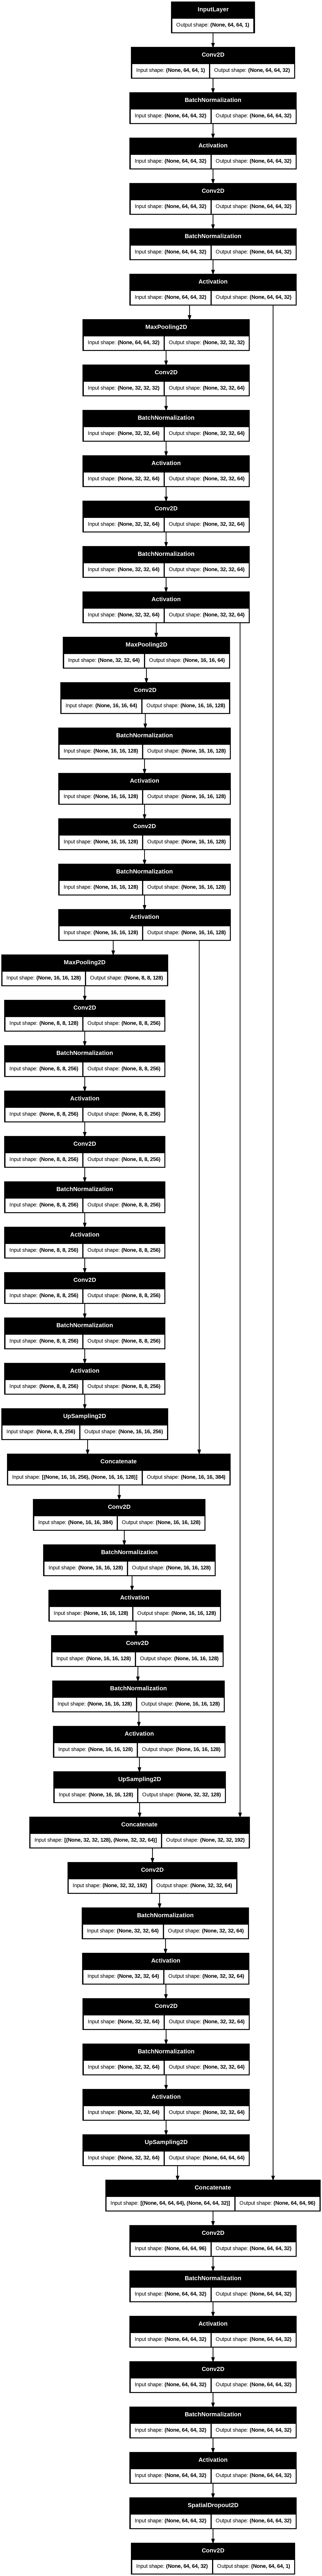

In [ ]:
#------------------------------------------------------------
# Data augmentation
#------------------------------------------------------------
smooth = 1

image_datagen = image.ImageDataGenerator(zoom_range=0.1,
                                        rotation_range=5,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1)
mask_datagen  = image.ImageDataGenerator(zoom_range=0.1,
                                        rotation_range=5,
                                        rescale=1./255.,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1)

seed = 1
input_shape = (64, 64)
output_shape = (64, 64)
batch_size = 32

image_generator = image_datagen.flow_from_directory(
    'data/train/image',
    class_mode=None,
    seed=seed,
    shuffle=True,
    batch_size=batch_size,
    target_size=output_shape,
    color_mode='grayscale')

mask_generator = mask_datagen.flow_from_directory(
    'data/train/mask',
    class_mode=None,
    seed=seed,
    shuffle=True,
    batch_size=batch_size,
    target_size=output_shape,
    color_mode='grayscale')

train_generator = (pair for pair in zip(image_generator, mask_generator))

seed = 1

valid_image_generator = image_datagen.flow_from_directory(
    'data/valid/image',
    class_mode=None,
    seed=seed,
    shuffle=True,
    batch_size=batch_size,
    target_size=output_shape,
    color_mode='grayscale')

valid_mask_generator = mask_datagen.flow_from_directory(
    'data/valid/mask',
    class_mode=None,
    seed=seed,
    shuffle=True,
    batch_size=batch_size,
    target_size=output_shape,
    color_mode='grayscale')

valid_generator = (pair for pair in zip(image_generator, mask_generator))


#------------------------------------------------------------
# Functions to save intermediate weights
#------------------------------------------------------------
class WeightsRecorder(tf.keras.callbacks.Callback):
    def __init__(self, progressFilePath):
        super(WeightsRecorder, self).__init__()
        self.progressFilePath = progressFilePath
        self.lastTimePoint = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch += 1
        training_loss = logs["loss"]
        validation_loss = logs["val_loss"]
        training_dice = logs["dice_coef"]
        validation_dice = logs["val_dice_coef"]
        ellapsed = "%0.1f" % (time.time() - self.lastTimePoint)
        self.lastTimePoint = time.time()
        with open(self.progressFilePath, "a") as outputFile:
            writer = csv.DictWriter(outputFile, lineterminator='\n', fieldnames=["epoch","time(s)","training_loss","validation_loss", "training_dice","validation_dice"])
            writer.writerow({"epoch": epoch,"time(s)": ellapsed, "training_loss": training_loss,"validation_loss": validation_loss, "training_dice": training_dice, "validation_dice": validation_dice})


outputDirPath = "training_output"
if not os.path.isdir(outputDirPath):
  os.mkdir(outputDirPath)

progressFilePath = os.path.join(outputDirPath, "liver_2D_training_progress.csv")
if not os.path.isfile(progressFilePath):
    with open(progressFilePath, "w") as outputFile:
        writer = csv.DictWriter(outputFile, lineterminator='\n', fieldnames=["epoch","time(s)","training_loss","validation_loss", "training_dice","validation_dice"])
        writer.writeheader()
recorder = WeightsRecorder(progressFilePath)

weight_saver = ModelCheckpoint(os.path.join(outputDirPath, 'liver_model.{epoch:02d}-{val_loss:.2f}-{val_dice_coef:.2f}.h5'),save_best_only=False, save_weights_only=False)
callbackList = [recorder, weight_saver]

#------------------------------------------------------------
# Build model and compile
#------------------------------------------------------------
model = get_simple_unet(input_shape)
model.compile(optimizer=Adam(2e-5), loss=tf.keras.losses.binary_crossentropy, metrics=[dice_coef])

#------------------------------------------------------------
# Visualize model
#------------------------------------------------------------
utils.plot_model(model,show_shapes=True)



In [ ]:
#------------------------------------------------------------
# Start training
#------------------------------------------------------------
hist=model.fit(train_generator, validation_data=valid_generator, validation_steps=20,
            steps_per_epoch=50, epochs=50, callbacks=callbackList)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - dice_coef: 0.0444 - loss: 0.8507

50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 430ms/step - dice_coef: 0.0446 - loss: 0.8501 - val_dice_coef: 0.0523 - val_loss: 0.7533
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - dice_coef: 0.0657 - loss: 0.7289

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 407ms/step - dice_coef: 0.0658 - loss: 0.7281 - val_dice_coef: 0.0471 - val_loss: 0.6674
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - dice_coef: 0.0837 - loss: 0.5869

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 402ms/step - dice_coef: 0.0837 - loss: 0.5865 - val_dice_coef: 0.0604 - val_loss: 0.6133
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - dice_coef: 0.0821 - loss: 0.5095

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - dice_coef: 0.0822 - loss: 0.5091 - val_dice_coef: 0.0728 - val_loss: 0.5425
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - dice_coef: 0.0919 - loss: 0.4527

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 402ms/step - dice_coef: 0.0919 - loss: 0.4525 - val_dice_coef: 0.0762 - val_loss: 0.4735
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - dice_coef: 0.0927 - loss: 0.4165

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 400ms/step - dice_coef: 0.0927 - loss: 0.4163 - val_dice_coef: 0.0875 - val_loss: 0.4438
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - dice_coef: 0.0966 - loss: 0.3901

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 407ms/step - dice_coef: 0.0966 - loss: 0.3901 - val_dice_coef: 0.0983 - val_loss: 0.4097
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - dice_coef: 0.1029 - loss: 0.3749

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - dice_coef: 0.1029 - loss: 0.3749 - val_dice_coef: 0.0929 - val_loss: 0.4181
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - dice_coef: 0.1122 - loss: 0.3581

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 401ms/step - dice_coef: 0.1122 - loss: 0.3580 - val_dice_coef: 0.0926 - val_loss: 0.3496
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - dice_coef: 0.1066 - loss: 0.3440

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - dice_coef: 0.1067 - loss: 0.3440 - val_dice_coef: 0.0994 - val_loss: 0.3330
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - dice_coef: 0.1062 - loss: 0.3344

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - dice_coef: 0.1062 - loss: 0.3343 - val_dice_coef: 0.1045 - val_loss: 0.3156
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - dice_coef: 0.1064 - loss: 0.3210

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 409ms/step - dice_coef: 0.1065 - loss: 0.3210 - val_dice_coef: 0.1188 - val_loss: 0.3105
Epoch 13/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - dice_coef: 0.1128 - loss: 0.3156

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 400ms/step - dice_coef: 0.1128 - loss: 0.3155 - val_dice_coef: 0.1196 - val_loss: 0.2982
Epoch 14/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - dice_coef: 0.1087 - loss: 0.3040

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - dice_coef: 0.1089 - loss: 0.3039 - val_dice_coef: 0.1227 - val_loss: 0.2917
Epoch 15/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - dice_coef: 0.1079 - loss: 0.2979

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - dice_coef: 0.1079 - loss: 0.2978 - val_dice_coef: 0.1230 - val_loss: 0.2834
Epoch 16/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - dice_coef: 0.1275 - loss: 0.2865

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 405ms/step - dice_coef: 0.1275 - loss: 0.2865 - val_dice_coef: 0.1156 - val_loss: 0.2794
Epoch 17/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - dice_coef: 0.1147 - loss: 0.2818

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 405ms/step - dice_coef: 0.1148 - loss: 0.2818 - val_dice_coef: 0.1253 - val_loss: 0.2717
Epoch 18/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - dice_coef: 0.1310 - loss: 0.2723

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 401ms/step - dice_coef: 0.1309 - loss: 0.2723 - val_dice_coef: 0.1175 - val_loss: 0.2671
Epoch 19/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - dice_coef: 0.1326 - loss: 0.2670

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - dice_coef: 0.1325 - loss: 0.2670 - val_dice_coef: 0.1375 - val_loss: 0.2646
Epoch 20/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - dice_coef: 0.1178 - loss: 0.2631

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 407ms/step - dice_coef: 0.1181 - loss: 0.2631 - val_dice_coef: 0.1237 - val_loss: 0.2595
Epoch 21/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - dice_coef: 0.1284 - loss: 0.2582

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 400ms/step - dice_coef: 0.1284 - loss: 0.2581 - val_dice_coef: 0.1266 - val_loss: 0.2513
Epoch 22/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - dice_coef: 0.1362 - loss: 0.2550

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - dice_coef: 0.1362 - loss: 0.2549 - val_dice_coef: 0.1148 - val_loss: 0.2473
Epoch 23/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - dice_coef: 0.1335 - loss: 0.2481

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - dice_coef: 0.1336 - loss: 0.2480 - val_dice_coef: 0.1353 - val_loss: 0.2421
Epoch 24/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - dice_coef: 0.1289 - loss: 0.2456

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 402ms/step - dice_coef: 0.1289 - loss: 0.2456 - val_dice_coef: 0.1548 - val_loss: 0.2415
Epoch 25/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - dice_coef: 0.1399 - loss: 0.2379

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - dice_coef: 0.1399 - loss: 0.2379 - val_dice_coef: 0.1345 - val_loss: 0.2353
Epoch 26/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - dice_coef: 0.1327 - loss: 0.2381

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - dice_coef: 0.1327 - loss: 0.2381 - val_dice_coef: 0.1363 - val_loss: 0.2311
Epoch 27/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - dice_coef: 0.1507 - loss: 0.2303

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 408ms/step - dice_coef: 0.1505 - loss: 0.2303 - val_dice_coef: 0.1472 - val_loss: 0.2309
Epoch 28/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - dice_coef: 0.1424 - loss: 0.2317

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 401ms/step - dice_coef: 0.1424 - loss: 0.2317 - val_dice_coef: 0.1417 - val_loss: 0.2228
Epoch 29/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - dice_coef: 0.1477 - loss: 0.2283

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - dice_coef: 0.1475 - loss: 0.2283 - val_dice_coef: 0.1433 - val_loss: 0.2192
Epoch 30/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - dice_coef: 0.1449 - loss: 0.2262

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - dice_coef: 0.1448 - loss: 0.2262 - val_dice_coef: 0.1516 - val_loss: 0.2160
Epoch 31/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - dice_coef: 0.1535 - loss: 0.2188

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 405ms/step - dice_coef: 0.1535 - loss: 0.2188 - val_dice_coef: 0.1311 - val_loss: 0.2128
Epoch 32/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - dice_coef: 0.1444 - loss: 0.2208

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 402ms/step - dice_coef: 0.1443 - loss: 0.2208 - val_dice_coef: 0.1393 - val_loss: 0.2088
Epoch 33/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - dice_coef: 0.1593 - loss: 0.2141

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - dice_coef: 0.1592 - loss: 0.2140 - val_dice_coef: 0.1495 - val_loss: 0.2057
Epoch 34/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - dice_coef: 0.1559 - loss: 0.2128

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - dice_coef: 0.1558 - loss: 0.2128 - val_dice_coef: 0.1539 - val_loss: 0.2025
Epoch 35/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - dice_coef: 0.1376 - loss: 0.2124

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 408ms/step - dice_coef: 0.1377 - loss: 0.2123 - val_dice_coef: 0.1641 - val_loss: 0.1990
Epoch 36/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - dice_coef: 0.1600 - loss: 0.2087

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 400ms/step - dice_coef: 0.1599 - loss: 0.2087 - val_dice_coef: 0.1636 - val_loss: 0.1959
Epoch 37/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - dice_coef: 0.1465 - loss: 0.2013

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 405ms/step - dice_coef: 0.1468 - loss: 0.2013 - val_dice_coef: 0.1647 - val_loss: 0.1935
Epoch 38/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - dice_coef: 0.1674 - loss: 0.2019

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 405ms/step - dice_coef: 0.1672 - loss: 0.2019 - val_dice_coef: 0.1512 - val_loss: 0.1900
Epoch 39/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - dice_coef: 0.1560 - loss: 0.2018

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - dice_coef: 0.1561 - loss: 0.2018 - val_dice_coef: 0.1506 - val_loss: 0.1890
Epoch 40/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - dice_coef: 0.1527 - loss: 0.1964

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - dice_coef: 0.1528 - loss: 0.1964 - val_dice_coef: 0.1727 - val_loss: 0.1867
Epoch 41/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - dice_coef: 0.1599 - loss: 0.1947

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - dice_coef: 0.1598 - loss: 0.1947 - val_dice_coef: 0.1616 - val_loss: 0.1836
Epoch 42/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - dice_coef: 0.1696 - loss: 0.1918

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 409ms/step - dice_coef: 0.1695 - loss: 0.1918 - val_dice_coef: 0.1779 - val_loss: 0.1840
Epoch 43/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - dice_coef: 0.1701 - loss: 0.1887

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 401ms/step - dice_coef: 0.1701 - loss: 0.1887 - val_dice_coef: 0.1531 - val_loss: 0.1771
Epoch 44/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - dice_coef: 0.1604 - loss: 0.1890

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - dice_coef: 0.1605 - loss: 0.1890 - val_dice_coef: 0.1727 - val_loss: 0.1756
Epoch 45/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - dice_coef: 0.1567 - loss: 0.1857

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - dice_coef: 0.1570 - loss: 0.1857 - val_dice_coef: 0.1782 - val_loss: 0.1758
Epoch 46/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - dice_coef: 0.1750 - loss: 0.1841

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - dice_coef: 0.1749 - loss: 0.1841 - val_dice_coef: 0.1621 - val_loss: 0.1721
Epoch 47/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - dice_coef: 0.1583 - loss: 0.1844

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - dice_coef: 0.1585 - loss: 0.1843 - val_dice_coef: 0.1716 - val_loss: 0.1705
Epoch 48/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - dice_coef: 0.1732 - loss: 0.1819

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - dice_coef: 0.1731 - loss: 0.1818 - val_dice_coef: 0.1700 - val_loss: 0.1685
Epoch 49/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - dice_coef: 0.1663 - loss: 0.1782

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - dice_coef: 0.1664 - loss: 0.1781 - val_dice_coef: 0.1893 - val_loss: 0.1673
Epoch 50/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - dice_coef: 0.1771 - loss: 0.1769

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 411ms/step - dice_coef: 0.1770 - loss: 0.1769 - val_dice_coef: 0.1695 - val_loss: 0.1640


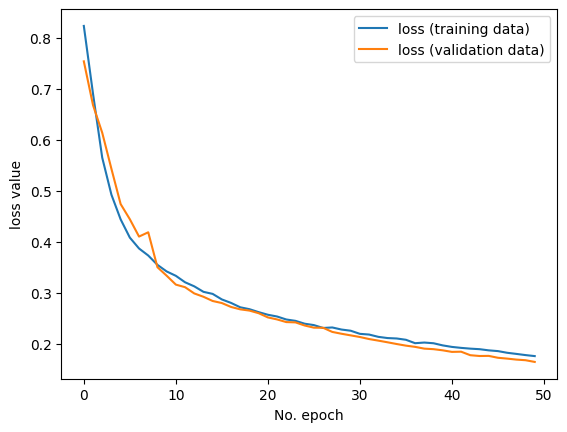

In [ ]:
#------------------------------------------------------------
# Plot history: cross-entropy
#------------------------------------------------------------
plt.plot(hist.history['loss'], label='loss (training data)')
plt.plot(hist.history['val_loss'], label='loss (validation data)')
plt.ylabel('loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

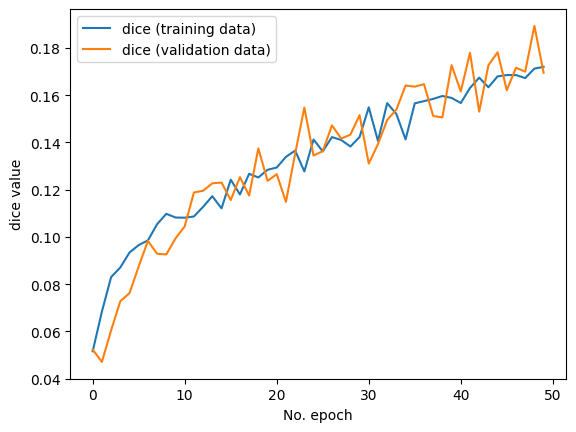

In [ ]:
#------------------------------------------------------------
# Plot history: dice coeff
#------------------------------------------------------------
plt.plot(hist.history['dice_coef'], label='dice (training data)')
plt.plot(hist.history['val_dice_coef'], label='dice (validation data)')
plt.ylabel('dice value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
#------------------------------------------------------------
# Helper functions for visualizing segmentations
#------------------------------------------------------------
def getBGRWithOverlay(image, mask, alpha=0.5, color=(0,255,0)):
    overlay = image.copy()
    output = image.copy()
    overlay[:,:,0][mask!=0] = color[0]
    overlay[:,:,1][mask!=0] = color[1]
    overlay[:,:,2][mask!=0] = color[2]
    cv2.addWeighted(overlay, alpha, output, 1-alpha, 0, output)
    return output
def getGrayWithOverlay(image, mask, alpha=0.5, color=(0,255,0)):
    image = grayToBGR(image)
    return getBGRWithOverlay(image, mask, alpha=alpha, color=color)

def grayToBGR(gray):
    grayDims = gray.shape
    grayBGR = np.zeros((grayDims[0], grayDims[1], 3), np.uint8)
    grayBGR[:,:,0] = gray
    grayBGR[:,:,1] = gray
    grayBGR[:,:,2] = gray
    return grayBGR

In [ ]:
#------------------------------------------------------------
# Load training set for visualization
#------------------------------------------------------------
imgDirPath_train = "data/train/image/dummy_class"
imgFilePathList_train = glob.glob(os.path.join(imgDirPath_train, "*.png"))
imgFilePathList_train = sorted(imgFilePathList_train)

maskDirPath_train = "data/train/mask/dummy_class"
maskFilePathList_train = glob.glob(os.path.join(maskDirPath_train, "*.png"))
maskFilePathList_train = sorted(maskFilePathList_train)

In [ ]:
#------------------------------------------------------------
# Load the weights from an early epoch
#------------------------------------------------------------
liverWeightsFilePath = "/content/training_output/liver_model.02-0.67-0.05.h5"
modelLiver = get_simple_unet((256,256))
modelLiver.load_weights(liverWeightsFilePath)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


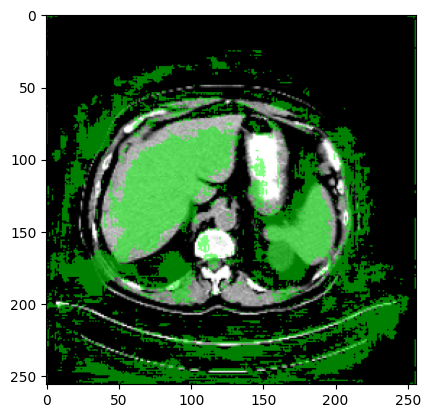

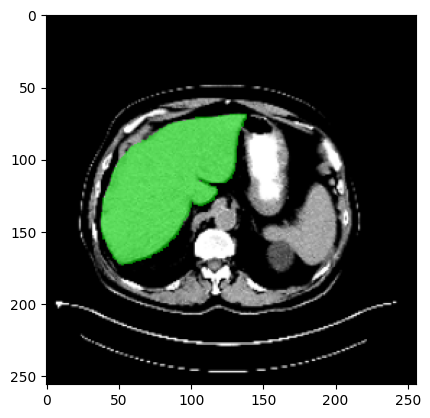

data/train/image/dummy_class/1093903054144_292846890701_axial_0076.png


In [ ]:
#------------------------------------------------------------
# Show an example segmentation
#------------------------------------------------------------
img_index = 250
imgFilePath = imgFilePathList_train[img_index]
img = cv2.imread(imgFilePath,0)
img = cv2.resize(img, (256,256))
imgOrig = img.copy()
img = img[np.newaxis, :, :, np.newaxis]

# predicted mask
resultLiver = modelLiver.predict(img)[0,:,:,0]
predictedmaskLiver = resultLiver > 0.5

# ground truth mask
maskFilePath = maskFilePathList_train[img_index]
mask_orig = cv2.imread(maskFilePath,0)
mask_orig = cv2.resize(mask_orig, (256,256))

overlay_predicted = getGrayWithOverlay(imgOrig, predictedmaskLiver, alpha=0.5, color=(0,255,0))
overlay_groundtruth = getGrayWithOverlay(imgOrig, mask_orig, alpha=0.5, color=(0,255,0))

imshow(overlay_predicted)
show()
imshow(overlay_groundtruth)
show()
print(imgFilePath)

In [ ]:
#------------------------------------------------------------
# Load the weights from a late epoch
#------------------------------------------------------------
liverWeightsFilePath = "/content/training_output/liver_model.49-0.17-0.19.h5"
modelLiver = get_simple_unet((256,256))
modelLiver.load_weights(liverWeightsFilePath)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


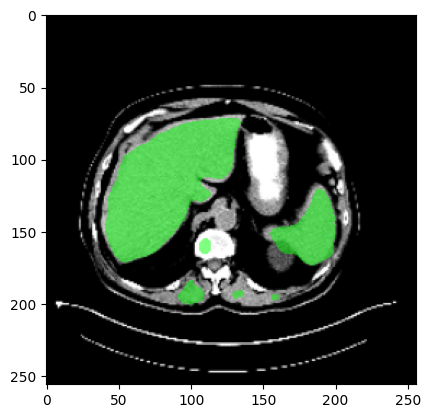

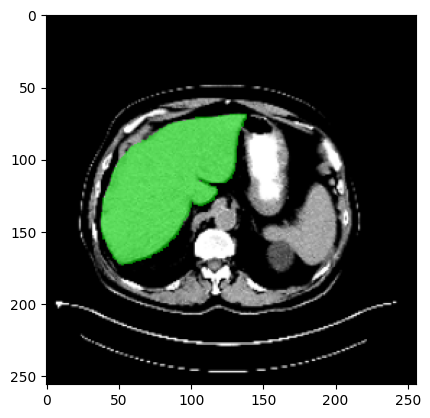

data/train/image/dummy_class/1093903054144_292846890701_axial_0076.png


In [ ]:
#------------------------------------------------------------
# Show an example segmentation
#------------------------------------------------------------
img_index = 250
imgFilePath = imgFilePathList_train[img_index]
img = cv2.imread(imgFilePath,0)
img = cv2.resize(img, (256,256))
imgOrig = img.copy()
img = img[np.newaxis, :, :, np.newaxis]

# predicted mask
resultLiver = modelLiver.predict(img)[0,:,:,0]
predictedmaskLiver = resultLiver > 0.5

# ground truth mask
maskFilePath = maskFilePathList_train[img_index]
mask_orig = cv2.imread(maskFilePath,0)
mask_orig = cv2.resize(mask_orig, (256,256))

overlay_predicted = getGrayWithOverlay(imgOrig, predictedmaskLiver, alpha=0.5, color=(0,255,0))
overlay_groundtruth = getGrayWithOverlay(imgOrig, mask_orig, alpha=0.5, color=(0,255,0))

imshow(overlay_predicted)
show()
imshow(overlay_groundtruth)
show()
print(imgFilePath)